# Counting Objects in Multiple Zones




---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/15IOySuPZlVhS-2zwNkF1IVm1PKIu7Ub4?authuser=0#scrollTo=icvH7schJ9Vk)

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit -> Notebook settings -> Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Wed Feb 14 00:40:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Install required packages

In [ ]:
!pip install -q ultralytics supervision==0.18.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 710.2/710.2 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 6.6 MB/s eta 0:00:00


# Imports

In [ ]:
import numpy as np
import supervision as sv
from ultralytics import YOLO
from supervision.assets import download_assets, VideoAssets

# Download a Supervision video asset

In [ ]:
path_to_video = download_assets(VideoAssets.MARKET_SQUARE)

  0%|          | 0/21302928 [00:00<?, ?it/s]

# Use Supervision to save the first frame of the video to draw the polygons.

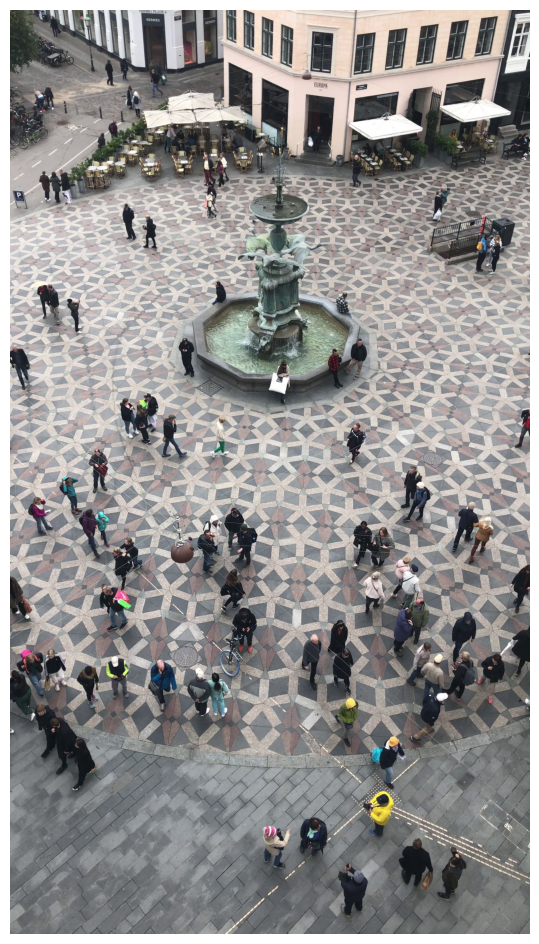

In [ ]:
generator = sv.get_video_frames_generator(path_to_video)
frame = next(generator)
sv.plot_image(frame, (12, 12))

# Run Object Detection
Let's start by running the detection model on the first frame and annotating the results. In this cookbook, we use [Ultralytics](https://github.com/ultralytics/ultralytics) YOLOv8, but it can be successfully replaced with [other models](https://supervision.roboflow.com/latest/detection/core/).

We initiate the model and perform detection on the first frame of the video. Then, we convert the result into a [sv.Detections](https://supervision.roboflow.com/latest/detection/core/) object, which will be useful in the later parts of the cookbook.

In [ ]:
model = YOLO("yolov8x.pt")

results = model(frame, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

100%|██████████| 131M/131M [00:00<00:00, 178MB/s]


The results we've obtained can be easily visualized with [sv.BoundingBoxAnnotator](https://supervision.roboflow.com/latest/annotators/#supervision.annotators.core.BoundingBoxAnnotator). By default, this annotator uses the same color to highlight objects of the same category. However, with the integration of a [tracker](https://supervision.roboflow.com/latest/trackers/), it becomes possible to assign unique colors to each tracked object. We can easily define our own [color palettes](https://supervision.roboflow.com/latest/draw/color/#supervision.draw.color.ColorPalette) and adjust parameters such as line thickness, allowing for a highly tailored visualization experience.

In [ ]:
bounding_box_annotator = sv.BoundingBoxAnnotator(thickness=4)
annotated_frame = bounding_box_annotator.annotate(frame.copy(), detections)
sv.plot_image(annotated_frame, (12, 12))

# Improve Visualizations

Supervision annotators can be easily combined with one another. Let's enhance our visualization by adding [sv.LabelAnnotator](https://supervision.roboflow.com/latest/annotators/#supervision.annotators.core.PolygonAnnotator.annotate), which we will use to mark detections with a label indicating their category and confidence level.

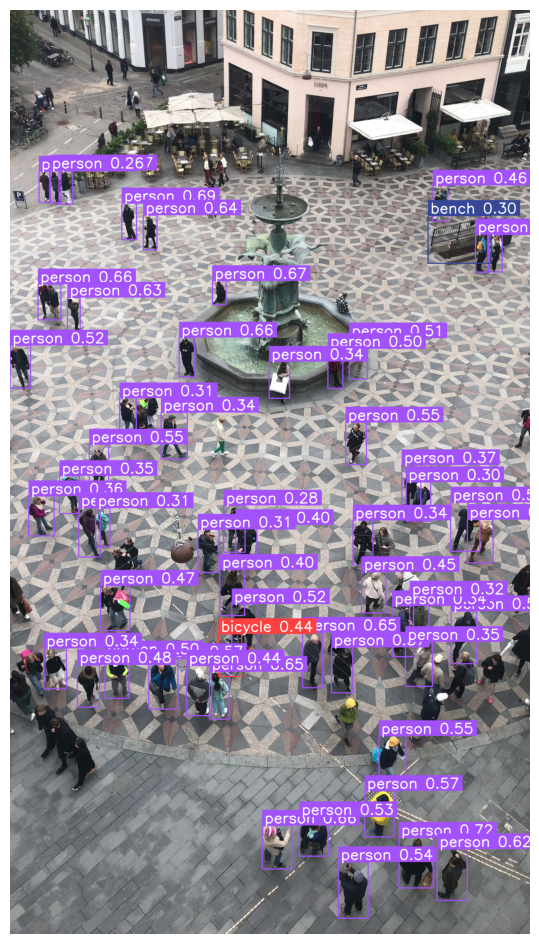

In [ ]:
labels = [
    f"{results.names[class_id]} {confidence:0.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

bounding_box_annotator = sv.BoundingBoxAnnotator(thickness=4)
label_annotator = sv.LabelAnnotator(text_thickness=4, text_scale=2)

annotated_frame = frame.copy()
annotated_frame = bounding_box_annotator.annotate(annotated_frame, detections)
annotated_frame = label_annotator.annotate(annotated_frame, detections, labels)
sv.plot_image(annotated_frame, (12, 12))

# Define polygons.

We can use [VideoInfo.from_video_path](https://supervision.roboflow.com/develop/utils/video/#supervision.utils.video.VideoInfo) to learn basic information about our video, such as duration, resolution, or FPS.

In [ ]:
h = sv.VideoInfo.from_video_path(path_to_video).height
w = sv.VideoInfo.from_video_path(path_to_video).width
sv.VideoInfo.from_video_path(path_to_video)

VideoInfo(width=2160, height=3840, fps=60, total_frames=474)

With a known height and width, we can make 4 equal zones on the video.

In [ ]:
top_left_polygon = np.array([[0, 0], [0, h/2], [w/2, h/2], [w/2, 0]], dtype=np.int32)
top_right_polygon = np.array([[0, h/2], [0, h], [w/2, h], [w/2, h/2]], dtype=np.int32)
bottom_left_polygon = np.array([[w/2, 0], [w/2, h/2], [w, h/2], [w, 0]], dtype=np.int32)
bottom_right_polygon = np.array([[w/2, h/2], [w/2, h], [w, h], [w, h/2]], dtype=np.int32)

# Initatiate Polygon Zones and Annotators

The polygons we've created can be visualized using [sv.PolygonZone](https://supervision.roboflow.com/latest/detection/tools/polygon_zone/). This tool also allows for polygons to be displayed on the video.

The count of each people in each polygon will be displayed using [sv.PolygonZoneAnnotator](https://supervision.roboflow.com/latest/detection/tools/polygon_zone/#polygonzoneannotator).



In [ ]:
video_info = sv.VideoInfo.from_video_path(path_to_video)

top_left= sv.PolygonZone(polygon=top_left_polygon, frame_resolution_wh=video_info.resolution_wh)
top_right = sv.PolygonZone(polygon=top_right_polygon, frame_resolution_wh=video_info.resolution_wh)
bottom_left = sv.PolygonZone(polygon=bottom_left_polygon, frame_resolution_wh=video_info.resolution_wh)
bottom_right = sv.PolygonZone(polygon=bottom_right_polygon, frame_resolution_wh=video_info.resolution_wh)

box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)

top_left_annotator = sv.PolygonZoneAnnotator(zone=top_left, color=sv.Color.white(), thickness=6, text_thickness=6, text_scale=4)
top_right_annotator = sv.PolygonZoneAnnotator(zone=top_right, color=sv.Color.white(), thickness=6, text_thickness=6, text_scale=4)
bottom_left_annotator = sv.PolygonZoneAnnotator(zone=bottom_left, color=sv.Color.white(), thickness=6, text_thickness=6, text_scale=4)
bottom_right_annotator = sv.PolygonZoneAnnotator(zone=bottom_right, color=sv.Color.white(), thickness=6, text_thickness=6, text_scale=4)

<ipython-input-11-ce03c231ee6a>:10: DeprecationWarning: white is deprecated: `Color.white()` is deprecated and will be removed in `supervision-0.20.0`. Use `Color.WHITE` instead.
  top_left_annotator = sv.PolygonZoneAnnotator(zone=top_left, color=sv.Color.white(), thickness=6, text_thickness=6, text_scale=4)
<ipython-input-11-ce03c231ee6a>:11: DeprecationWarning: white is deprecated: `Color.white()` is deprecated and will be removed in `supervision-0.20.0`. Use `Color.WHITE` instead.
  top_right_annotator = sv.PolygonZoneAnnotator(zone=top_right, color=sv.Color.white(), thickness=6, text_thickness=6, text_scale=4)
<ipython-input-11-ce03c231ee6a>:12: DeprecationWarning: white is deprecated: `Color.white()` is deprecated and will be removed in `supervision-0.20.0`. Use `Color.WHITE` instead.
  bottom_left_annotator = sv.PolygonZoneAnnotator(zone=bottom_left, color=sv.Color.white(), thickness=6, text_thickness=6, text_scale=4)
<ipython-input-11-ce03c231ee6a>:13: DeprecationWarning: white 

# Process Video

All the operations we plan to perform for each frame of our video - detection, annotation, and counting - are encapsulated in a function named callback.

In [ ]:
def callback(frame: np.ndarray, _) -> np.ndarray:
   results = model(frame, imgsz=1280, verbose=False)[0]
   detections = sv.Detections.from_ultralytics(results)
   detections = detections[detections.class_id == 0] #since we are only worried about the first class, which is "person"
   top_right.trigger(detections=detections)
   top_left.trigger(detections=detections)
   bottom_left.trigger(detections=detections)
   bottom_right.trigger(detections=detections)

   box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
   labels = [
        f"#{model.model.names[class_id]} {confidence:0.2f}"
        for confidence, class_id
        in zip(detections.confidence, detections.class_id)
    ]
   frame = box_annotator.annotate(scene=frame, detections=detections, labels=labels)
   frame = top_right_annotator.annotate(scene=frame)
   frame = top_left_annotator.annotate(scene=frame)
   frame = bottom_right_annotator.annotate(scene=frame)
   frame = bottom_left_annotator.annotate(scene=frame)

   return frame

Finally, we are ready to process our entire video. We will use [sv.process_video](https://supervision.roboflow.com/develop/utils/video/#supervision.utils.video.process_video) and pass to it the previously defined SOURCE_VIDEO_PATH, TARGET_VIDEO_PATH, and `callback`.

In [ ]:
SOURCE_VIDEO_PATH = path_to_video
TARGET_VIDEO_PATH = "output.mp4"

In [ ]:
sv.process_video(SOURCE_VIDEO_PATH, TARGET_VIDEO_PATH, callback = callback)